In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("final-project-hill.ipynb")

# Final Project: Hill cipher

This choice for the final project will focus on the [Hill cipher](https://en.wikipedia.org/wiki/Hill_cipher).

From Wikipedia:
>In classical cryptography, the Hill cipher is a polygraphic substitution cipher based on linear algebra. Invented by Lester S. Hill in 1929, it was the first polygraphic cipher in which it was practical (though barely) to operate on more than three symbols at once.

You will investigate how to create the key and implement the encryption / decryption algorithms in Python.

## Import your toolkit

You are provided the following functions to help complete this assignment:
* `text_clean(<string>, <LETTERS>)`
* `text_block(<string>, <blocksize>)`
* `multiplicative_inverse(<integer>, <modulus>)` which returns `False` if no inverse exists

Run the cell below to import these assignments

In [ ]:
from finaltoolkit import text_clean, text_block, multiplicative_inverse

## The Encryption key

The Hill cipher uses a square [matrix](https://en.wikipedia.org/wiki/Matrix_(mathematics) as the key, typically with dimensions of either 2x2 or 3x3, but the process can be generalized to an $n$x$n$ matrix.

There is a package, `numpy` which allows you to use Python to perform many common matrix operations. Run the cell below to load `numpy`. You will soon learn how to use this package to perform matrix operations.

In [ ]:
import numpy as np

### Question 1: Creating a square matrix using `numpy`

`numpy` uses a new data type called an `array` to work with matrices. There are a few different ways you can create an array object.

Each of the following code examples will create the array that represents the matrix $A$ shown below:

$$A = \begin{bmatrix}
   1 & 2 & 3 \\
   4 & 5 & 6 \\
   7 & 8 & 9
\end{bmatrix}
$$

The first way is to pass a list of lists to `np.array()` where each of the sublists represents a row of the matrix.

In [ ]:
np.array([[1,2,3],[4,5,6],[7,8,9]])

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

The second way is to create a single row of the values in order you want the values to appear from left to right, top to bottom. Then, use the `reshape(<row>, <column>)` method to resize those values into the correct dimensions.

In [ ]:
np.array([1,2,3,4,5,6,7,8,9]).reshape((3,3))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

Assign the following variables as `numpy` arrays that match their mathematical definitions:

$$A = \begin{bmatrix}
   6 & 0 \\
   14 & 22 
\end{bmatrix}
$$

$$B = \begin{bmatrix}
   2 & 5 & 7 & 1 & 2 \\
   4 & 2 & 8 & 6 & 3 
\end{bmatrix}
$$

In [ ]:
A = np.array([[6, 0], [14, 22]])
A

array([[ 6,  0],
       [14, 22]])

In [ ]:
B = np.array([2, 5, 7, 1, 2, 4, 2, 8, 6, 3]).reshape(2,5)
B

array([[2, 5, 7, 1, 2],
       [4, 2, 8, 6, 3]])

In [ ]:
grader.check("q1")

### Question 2: Validating keys

Matrices are only valid for use as a key in the Hill cipher if they meet the following criteria:
* They are square (they have the same number of rows and columns)
  * You can ask `numpy` to tell you the shape of a matrix by calling `A.shape`. It will return a tuple/list that contains the row and column size. You can access them seperately by using an index (e.g. `A.shape[0]` is the row size, `A.shape[1]` is the column size.)
* They have a [determinant](https://en.wikipedia.org/wiki/Determinant) that is non-zero 
  * The determinant can be found using `numpy` with the `np.linalg.det(A)` function
* They have a determinant that has a multiplicative inverse in the given modulus (length of alphabet)
  * The multiplicative inverse can be found using the `multiplicative_inverse` function provided in the toolkit

Write a function `valid_key` that accepts a matrix (numpy array) and returns a boolean value `True` if the key is value and `False` if the key is invalid.

**Note:** Determinants of matrices that only contain integers should always be an integer value. However, sometimes `numpy` will have strange calculation errors that result in a float.

In [ ]:
np.linalg.det(A)

131.99999999999997

Use the `round` function to ensure that any weird computation artifacts are handled by rounding the float to an integer.

In [ ]:
round(np.linalg.det(A))

132

And then reduce to the appropriate modulo:

In [ ]:
round(np.linalg.det(A)) % 26

2

In [ ]:
def valid_key(A, LETTERS='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    if A.shape[0] != A.shape[1]:
        return False
    
    if round(np.linalg.det(A)) == 0:
        return False
    
    if multiplicative_inverse(round(np.linalg.det(A)) % len(LETTERS), len(LETTERS)) == False:
        return False
    
    return True

In [ ]:
grader.check("q2")

### Question 3: Creating a key

Typically a key is created by first choosing a keyword or phrase that is turned into numerical values and stored into the matrix.

Write the function `keygen` which takes in a keyword, cleans it, and then uses its length to determine the size of the matrix that should be used with the Hill cipher. That means that if the string `keyword` has length `n**2`, the square array should have the dimensions `n` by `n`. You may assume that the length of `keyword` is a perfect square and do not need to check for this.

**Hint**: Try creating a "flat" version of the key (essentially a single row array with all the correct numbers in order) and then use the `reshape` method to turn it into the correct square array.

In [ ]:
def keygen(keyword, LETTERS='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    cleaned_keyword = text_clean(keyword, LETTERS) # SOLUTION
    keyword_length = len(cleaned_keyword) # SOLUTION
    matrix_dimension = int(keyword_length ** 0.5) # SOLUTION
    
    # BEGIN SOLUTION NO PROMPT
    flat_key = []
    for char in cleaned_keyword:
        flat_key.append(LETTERS.find(char))
    
    key = np.array(flat_key).reshape((matrix_dimension, matrix_dimension))
    
    return key
    # END SOLUTION

In [ ]:
grader.check("q3")

## The Hill Cipher

To encrypt a message with the Hill cipher, break the message into blocks of each containing `n` characters, where `n` is also the size of your square key matrix. Write each block of characters as a single column matrix with `n` entries. Then, multiply this matrix by your key, and reduce modulo 26. The result will be a 1 x `n` matrix that represents the ciphertext version of the block. Repeat until the entire message is encrypted. If your last block doesn't have enough characters to create a full 1 x `n` matrix, pad the message with the character `X` until it's long enough to create a full block.


**Example:**

Create a 2 x 2 key:

$$K = \begin{bmatrix}
   3 & 6 \\
   1 & 3 
\end{bmatrix}
$$

Using the plaintext message, `ET PHONE HOME`, create 1 x 2 matrices that numerical represent the message:

$$\begin{bmatrix}
   E  \\
   T 
\end{bmatrix}, \begin{bmatrix}
   P  \\
   H 
\end{bmatrix}, \begin{bmatrix}
   O  \\
   N 
\end{bmatrix}, \begin{bmatrix}
   E  \\
   H 
\end{bmatrix}, \begin{bmatrix}
   O  \\
   M 
\end{bmatrix}, \begin{bmatrix}
   E  \\
   X 
\end{bmatrix}
$$

$$\begin{bmatrix}
   4  \\
   19 
\end{bmatrix}, \begin{bmatrix}
   15  \\
   7 
\end{bmatrix}, \begin{bmatrix}
   14  \\
   13
\end{bmatrix}, \begin{bmatrix}
   4  \\
   7 
\end{bmatrix}, \begin{bmatrix}
   14  \\
   12 
\end{bmatrix}, \begin{bmatrix}
   4  \\
   23 
\end{bmatrix}
$$

Then, multiply the key by each plaintext matrix to create the ciphertext. The first result is shown below:

$$\begin{bmatrix}
   3 & 6 \\
   1 & 3 
\end{bmatrix} \begin{bmatrix}
   4  \\
   19 
\end{bmatrix}= \begin{bmatrix}
   3 \cdot 4 + 6 \cdot 19 \\
   1 \cdot 4 + 3 \cdot 19
\end{bmatrix} = \begin{bmatrix}
   126 \\
   61 
\end{bmatrix} = \begin{bmatrix}
   22 \\
   9 
\end{bmatrix} = \begin{bmatrix}
   W \\
   J 
\end{bmatrix}
$$

The full ciphertext would be: `WJ JK QB CZ KY UV`

To decrypt the message, repeat the process using the inverse of the key matrix.

### Using `numpy` to perform multiplication

The process of multiplying two matrices together is also known as the **dot product** between two matrices. You can learn more about matrix multiplication by hand by watching [this video](https://www.youtube.com/watch?v=sYlOjyPyX3g&t=496s). Fortunately, `numpy` can perform the operation very quickly using the `np.dot()` function. You can then use the mod operation, `%` to perform the mod operation on each element in the matrix.

In [ ]:
K = np.array([[3, 6], [1,3]])
block = np.array([[4,19]]).reshape(2,1)

ciphertext_numerical = np.dot(K,block) % 26
ciphertext_numerical

array([[22],
       [ 9]])

To access each element in the array individual, you can use indexing (just like with lists of lists) to specify exactly which element to retrieve. For example, to access `22` you should specify the location of row 0, column 0:

In [ ]:
ciphertext_numerical[0][0]

22

And to retrieve 9, you should specify row 1, column 0:

In [ ]:
ciphertext_numerical[1][0]

9

### Question 4: Cleaning the message

When encrypting a message, the Hill Cipher requires that each block of characters fill the 1 x `n` matrix. Write a function `hill_textclean` that checks if a provided `message` would have a final block that is "full". If the message would not have a full final block, add the correct number of `X`s to the end of the message so it would.


In [ ]:
def hill_textclean(message, block_size, LETTERS='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    
    cleaned_message = text_clean(message, LETTERS)
    
    # BEGIN SOLUTION NO PROMPT
    while len(cleaned_message) % block_size != 0:
        cleaned_message += 'X'
    
    return cleaned_message
    # END SOLUTION

In [ ]:
grader.check("q4")

### Inverse matrices

Constructing the multiplicative inverse of a matrix can easily be done using `numpy`, however, `numpy` is not concerned about ensuring the resulting matrix contains only integer values. For example:

In [ ]:
K = np.array([[3, 6], [1,3]])
np.linalg.inv(K)

array([[ 1.        , -2.        ],
       [-0.33333333,  1.        ]])

Since we want each entry in our keys and messages to be integers (since they need to result in integers that represent characters) we'll need another way to compute the inverse that preserves the integer values. Let's dig into how an inverse matrix is created to learn how this works.

The inverse of a square matrix is computed by calculating the determinant of the matrix and multiplying it's reciprocal by the adjugate matrix. If the input matrix is comprised of integers, then the adjugate matrix is guaranteed to contain only integers as well.

$$A^{-1} = \frac{1}{\det{A}} \text{adj}(A) = (\det{A})^{-1} \text{adj}(A) $$

We've seen that `numpy` can compute the determinant with the `np.linalg.det()` function. Unfortunately, `numpy` doesn't have a way to directly compute the adjugate matrix. However, we can "trick" it into computing one. Rearranging the equation from above:

$$\text{adj}(A) = \det(A) A^{-1}$$



In [ ]:
K = np.array([[3, 6], [1,3]])
K_adj = np.linalg.det(K) * np.linalg.inv(K)
K_adj

array([[ 3., -6.],
       [-1.,  3.]])

**Note:** To ensure that each element is an integer (notice the . after each number indicating the computation resulted in a float), you must round it using the `numpy` matrix rounding function `np.round_()` and *then* convert the matrix to integers using the `.astype(int)` command.

See below:

In [ ]:
K_adj = np.round_(K_adj).astype(int)
K_adj

array([[ 3, -6],
       [-1,  3]])

To finish the process off, you'll need to compute the determinant, convert it to an integer, and then find it's multiplicative inverse in the correct modulo.

In [ ]:
determinant = int(round(np.linalg.det(K)))
det_inv = multiplicative_inverse( determinant, 26 )
det_inv

9

Lastly, multiply the multiplicative inverse of the determinant, `det_inv` by the adjugate matrix, `K_adj`, and reduce by the appropriate modulo.

In [ ]:
K_inv = (det_inv * K_adj) % 26
K_inv

array([[ 1, 24],
       [17,  1]])

We can confirm that `K` and `K_inv` are inverses of each other by finding their dot product and verifying that it's equivalent to the identity matrix, $I$, which contains the number 0 everywhere except on the diagonal from the top left corner to the bottom right corner whose elements are 1. The size of the identity matrix is the same as the key. So, for our example:

$$
I = \begin{bmatrix}
   1 & 0 \\
   0 & 1 
\end{bmatrix}
$$

In [ ]:
np.dot(K, K_inv) % 26

array([[1, 0],
       [0, 1]])

### Question 5: Compute the "Hill Inverse"

Write the function `hill_inverse` that computes the inverse of a provided square matrix, `K`, in the provided modulus `n`. You can assume that only valid keys will be passed to this function.

In [ ]:
def hill_inverse(K, n):
    K_adj = np.round_(np.linalg.det(K) * np.linalg.inv(K)).astype(int) # SOLUTION
    determinant = int(round(np.linalg.det(K))) # SOLUTION
    det_inv = multiplicative_inverse( determinant, n ) # SOLUTION
    return (det_inv * K_adj) % n # SOLUTION

In [ ]:
grader.check("q5")

### Question 6: Encryption / Decryption

At this point you should now be able write a function `hill` that implements the Hill cipher using a provided keyword, block size, and message. The function should also accept a boolean value to `encipher` that when set to `True` encrypts the `message` with the `key` and when set to `False` decrypts the `message` with the `key`.

In [ ]:
def hill(keyword, block_size, message, encipher=True, LETTERS='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    
    key = keygen(keyword, LETTERS) # SOLUTION
    
    # This code checks if the key is valid! If not, returns False
    if valid_key(key) == False:
        return False
        
    cleaned_message = hill_textclean(message, block_size, LETTERS) # SOLUTION
    output = ''
    
    # BEGIN SOLUTION NO PROMPT
    if encipher==False:
        key = hill_inverse(key, len(LETTERS))
            
    for i in range(0, len(cleaned_message), block_size):
        flat_block = []
        for j in range(i, i+block_size):
            flat_block.append(LETTERS.find(cleaned_message[j]))

        block = np.array(flat_block).reshape(block_size,1)

        output_block = np.dot(key, block) % len(LETTERS)

        for j in range(0,block_size):
            output += LETTERS[ output_block[j][0] ]           

    if encipher == False:
        return output.lower()
    else:
        return text_block(output, 5)
    # END SOLUTION

In [ ]:
grader.check("q6")

## Ciphertext analysis

There is a file included with this notebook that contains the first chapter of Pride and Prejudice. These responses will only be graded for accuracy once you've submitted your assignment, so make sure you are certain of your answers before submitting!

Run the cell below to load the chapter to the string named `plaintext`

In [ ]:
with open('pride-prejudice-chapter-01.txt') as f:
    plaintext = f.read()

<!-- BEGIN QUESTION -->

### Question 7: Creating a bar chart

Encrypt the plaintext using a keyword of `PRIDEANDP`, and block size `3`, then create a bar chart that shows the single character frequencies of each of the 25 English characters used in the message.

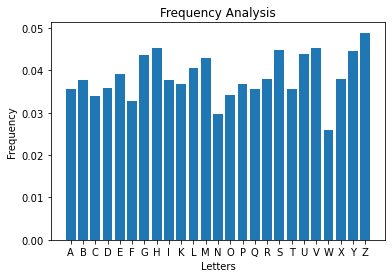

In [ ]:
ciphertext = hill('PRIDEANDP', 3, plaintext) # SOLUTION

# BEGIN SOLUTION NO PROMPT
import matplotlib.pyplot as plt
LETTERS = 'ABCDEFGHIKLMNOPQRSTUVWXYZ'
frequencies = []
ciphertext_length = len(ciphertext.replace(' ',''))

for char in LETTERS:
    frequencies.append( ciphertext.count(char) / ciphertext_length )
    
plt.bar(list(LETTERS), frequencies)
plt.xlabel('Letters')
plt.ylabel('Frequency')
plt.title('Frequency Analysis')

plt.show()
# END SOLUTION

<!-- END QUESTION -->

### Question 8: Index of Coincidence

Write a function `index_of_coincidence` to compute the index of coincidence of the ciphertext.

**Hint:** Reference Lesson 17 and Lab 04 if you need a refresher!

In [ ]:
def index_of_coincidence(message, LETTERS='ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    
    # BEGIN SOLUTION NO PROMPT    
    cleaned_message = text_clean(message, LETTERS)
    message_length = len(cleaned_message) 
    
    total = 0
    for char in LETTERS:
        total += ( cleaned_message.count(char) / message_length ) *  ( (cleaned_message.count(char)-1) / (message_length-1) )
    # END SOLUTION
    return total # SOLUTION

In [ ]:
grader.check("q8")

### Question 9: Classifying the cipher

The Hill cipher is what's known as a polygraphic cipher. It's not a monoalphabetic substitution cipher or a polyalphabetic substitution cipher.

Based on the coincidence value you computed in Question 8, which of the following does it behave *most* like:

1. monoalphabetic substitution cipher
2. polyalphabetic substitution cipher

Assign the answer choice as an integer to the variable `q9` below.

In [ ]:
q9 = 2 # SOLUTION

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Before exporting, SAVE your notebook, then RESTART AND RUN ALL CELLS. This will run the export cell. Make sure you submit the most recent copy by using the date-time stamp on the file.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)